### Problem Set 1
#### MACS 30250, Dr. Evans
#### Due Monday, May. 6 at 1:30pm
#### Haowen Shang

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")
import timeit
import random
import multiprocessing
import graphviz
from dask import delayed
from dask import compute
import dask.array as da
from statistics import mean

#### 1. 2D kernel density estimator

In [2]:
bq_data = np.loadtxt('data/BQmat_orig.txt', delimiter=',')
# Some diagnostics
print('Shape of bq_data', bq_data.shape)
print('Bequest distribution by income group:',
      bq_data.sum(axis=0))
print('Sum of all probabilities', bq_data.sum())

Shape of bq_data (78, 7)
Bequest distribution by income group: [0.01214584 0.00817072 0.01590964 0.0139963  0.01383075 0.06927237
 0.86667437]
Sum of all probabilities 1.0


#### (a)

Text(0.5, 0, 'Percent of BQ received')

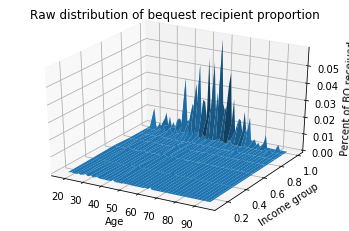

In [3]:
# Make 3D surface plot of rough bequests distribution matrix
age_vec = np.arange(18, 96)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])
income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Raw distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income group')
ax.set_zlabel('Percent of BQ received')

#### (b)

In [4]:
prob_inc = np.sum(bq_data, axis=0)
prob_age = np.sum(bq_data, axis=1)
num_sample = 10000

inc_probs = np.random.multinomial(num_sample, prob_inc)
age_probs = np.random.multinomial(num_sample, prob_age)

age_freq = np.array([])
inc_freq = np.array([])

In [5]:
# creating a distribution of age 
for age, num_s in zip(age_vec, age_probs):
    vec_age_s = np.ones(num_s)
    vec_age_s *= age
    age_freq = np.append(age_freq, vec_age_s)

# creating a distribution of income
for pct, num_j in zip(lambdas_mdpts, inc_probs):
    vec_abil_j = np.ones(num_j)
    vec_abil_j *= pct
    inc_freq = np.append(inc_freq, vec_abil_j)

In [6]:
# Selecting the bandwidth via cross-validation
bandwidths = 10** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths}, cv=5)
grid.fit(bq_data)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bandwidth': array([ 0.1    ,  0.10476, ...,  9.54548, 10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [7]:
grid.best_params_

{'bandwidth': 0.1}

 we can find the choice of bandwidth which maximizes the score (which in this case defaults to the log-likelihood) is 0.1 .

In [8]:
data = np.vstack((age_freq, inc_freq))
density = gaussian_kde(data, bw_method=grid.best_params_["bandwidth"])

coords = np.vstack([item.ravel() for item in [age_mat, income_mat]])
BQkde = density(coords).reshape(age_mat.shape)
BQkde_scaled = BQkde /np.sum(BQkde)

Text(0.5, 0, 'Percent of BQ received')

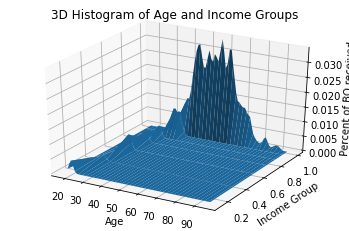

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, BQkde_scaled)
ax.set_title('3D Histogram of Age and Income Groups')
ax.set_xlabel('Age')
ax.set_ylabel('Income Group')
ax.set_zlabel('Percent of BQ received')

In [10]:
BQkde_scaled[42, 5]

2.469203514072113e-06

The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is 2.469203514072113e-06.

#### 2. Parallel computing versus serial computing a bootstrapped cross validation

In [11]:
df = pd.read_csv('data/Auto.csv',na_values = "?")
df.dropna(inplace=True)
df['orgn1'] = 0
df.orgn1[df['origin']==1] = 1
df['orgn2'] = 0
df.orgn2[df['origin']==2] = 1
Median = df['mpg'].median()
df['mpg_high'] = 0
df.mpg_high[df['mpg']>=Median] = 1

In [12]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,orgn1,orgn2,mpg_high
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,1,0,0


#### (a)

In [73]:
N_bs = 100

start_time = timeit.default_timer()
err_vec = np.zeros(N_bs)
X = df[['cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'year', 'orgn1', 'orgn2']].values
y = df.mpg_high.values

for bs_ind in range(N_bs):
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.35, random_state=1000+bs_ind)
    LogReg = LogisticRegression(n_jobs = None)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    err_vec[bs_ind] = (y_test == y_pred).mean()
    
mean_err = err_vec.mean()
elapsed_time = timeit.default_timer() - start_time

print('The average error rate =', mean_err)
print('Computation time=', elapsed_time)

The average error rate = 0.9005797101449277
Computation time= 0.17864910898788366


#### (b)

In [37]:
def paral_bs(bs_ind, seed, X, y):    
    X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=0.35, random_state=seed+bs_ind)
    LogReg = LogisticRegression(n_jobs = None)
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    return (y_test == y_pred).mean()

In [90]:
start_time = timeit.default_timer()
N_bs = 100
err_vec = []
X = df[['cylinders', 'displacement', 'horsepower', 'weight','acceleration', 'year', 'orgn1', 'orgn2']].values
y = df.mpg_high.values

for bs_ind in range(N_bs):
    sample_MSE = delayed(paral_bs(bs_ind, 1000, X, y))
    err_vec.append(sample_MSE)

mean_err = delayed(mean)(err_vec)
mean_err = compute(mean_err)
elapsed_time = timeit.default_timer() - start_time


print('The average error rate =', mean_err[0])
print('Computation time=', elapsed_time)

The average error rate = 0.9006521739130435
Computation time= 0.17683794899494387
